# Data Science Essentials: GeoPandas
    Daniel Perkins
    MATH 403
    9/17/24

In [1]:
import geopandas as gpd
from matplotlib import pyplot as plt
import pandas as pd
from shapely.geometry import Polygon
from matplotlib.colors import LogNorm
from matplotlib.cm import ScalarMappable
import matplotlib.animation as animation

## Problem 1

Read in the file *airports.csv* as a pandas DataFrame.
Create three convex hulls around the three sets of airports listed below.
This can be done by passing in lists of the airports' coordinates (Longitude and Latitude zipped together) to a *shapely.geometry.Polygon* object.

Then, create a new GeoDataFrame using a dictionary with key *'geometry'* and with a list of these three Polygons as the value.
Plot this GeoDataFrame, and then plot the outlined world map on top of it.

1. Maio Airport, Scatsta Airport, Stokmarknes Skagen Airport, Bekily Airport, K. D. Matanzima Airport, RAF Ascension Island
2. Oiapoque Airport, Maio Airport, Zhezkazgan Airport, Walton Airport, RAF Ascension Island, Usiminas Airport, Piloto Osvaldo Marques Dias Airport
3. Zhezkazgan Airport, Khanty Mansiysk Airport, Novy Urengoy Airport, Kalay Airport, Biju Patnaik Airport, Walton Airport

In [26]:
first_set = ['Maio Airport', 'Scatsta Airport', 'Stokmarknes Skagen Airport',
                 'Bekily Airport', 'K. D. Matanzima Airport', 'RAF Ascension Island']
second_set = ['Oiapoque Airport', 'Maio Airport', 'Zhezkazgan Airport',
                'Walton Airport', 'RAF Ascension Island', 'Usiminas Airport',
                 'Piloto Osvaldo Marques Dias Airport']
third_set = ['Zhezkazgan Airport', 'Khanty Mansiysk Airport', 'Novy Urengoy Airport',
                 'Kalay Airport', 'Biju Patnaik Airport', 'Walton Airport']

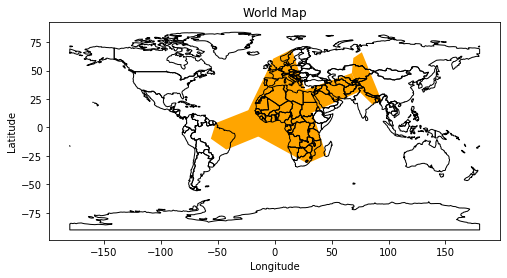

In [51]:
# Read in data
worldmap = gpd.read_file("worldmap.gpkg")
airports = gpd.read_file("airports.csv")
# print(airports)

# Get df that contains only specified data
first_mask = airports["Name"].isin(first_set)
first_group = airports[first_mask]
second_mask = airports["Name"].isin(second_set)
second_group = airports[second_mask]
third_mask = airports["Name"].isin(third_set)
third_group = airports[third_mask]

# Get the polygons
first_polygon = Polygon(list(zip(first_group.Longitude, first_group.Latitude)))
second_polygon = Polygon(list(zip(second_group.Longitude, second_group.Latitude)))
third_polygon = Polygon(list(zip(third_group.Longitude, third_group.Latitude)))

# Create new dataframe
newGeo = gpd.GeoDataFrame({"geometry": [first_polygon.convex_hull, second_polygon.convex_hull, third_polygon.convex_hull]})

# Plot the data
fig, ax = plt.subplots(1, figsize=(10, 4))
ax.set_title("World Map")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
base = worldmap.boundary.plot(edgecolor="black", ax=ax, linewidth=1)
newGeo.plot(ax=base, marker="o", color="orange", markersize=1)
plt.show()

## Problem 2

Use the command *geopandas.read_file('county_data.gpkg')* to create a GeoDataFrame of information about US counties.
Each county's shape is stored in the *geometry* column.
Use this to **plot the boundaries of all US counties two times**, first using the default CRS and then using EPSG:5071.

Next, create a new GeoDataFrame that combines (*dissolve*) all counties within each state (*by='STATEFP'*).
Drop regions with the following STATEFP codes: 02, 15, 60, 66, 69, 72, 78.
Plot the boundary of this GeoDataFrame to see an outline of the 48 contiguous states.
Ensure a CRS of 5071.

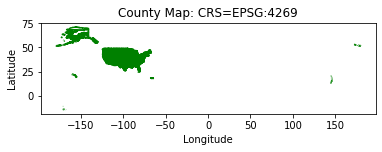

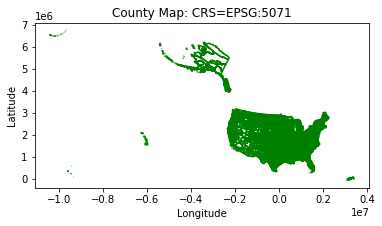

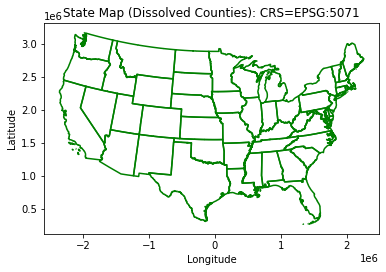

In [88]:
# Read the data
county_data = gpd.read_file("county_data.gpkg")

# Plot the data
county_data.boundary.plot(edgecolor="green", markersize=1)
plt.title(f"County Map: CRS={county_data.crs}")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

# Same thing but with different crs
county_data = county_data.to_crs(5071)
county_data.boundary.plot(edgecolor="green", markersize=1)
plt.title(f"County Map: CRS={county_data.crs}")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

# New data frame that dissolves all counties within each state
state_data = county_data.dissolve(by="STATEFP")  # Dissolve
# Drop states outside of continuental us
state_data = state_data.drop(["02", "15", "60", "66", "69", "72", "78"], axis="index")
state_data = state_data.to_crs(5071)
state_data.boundary.plot(edgecolor="green", markersize=1)
plt.title(f"State Map (Dissolved Counties): CRS={state_data.crs}")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

## Problem 3

Load in the file *nytimes.csv* as a Pandas DataFrame.
This file includes county-level data for the cumulative cases and deaths of Covid-19 in the US, starting with the first case in Snohomish County, Washington, on January 21, 2020.

Merge the county GeoDataFrame from *county_data.gpkg* with the *nytimes* DataFrame on the county *fips* codes (a FIPS code is a 5-digit unique identifier for geographic locations).
Note that the *fips* column of the *nytimes* DataFrame stores entries as floats, but the county GeoDataFrame stores FIPS codes as strings, with the first two digits in the *STATEFP* column and the last three digits in the *COUNTYFP* column.
Thus, you will need to add these two columns together and then convert them into floats so they can be merged with the *fips* column in the *nytimes* DataFrame.

Drop the regions from the county GeoDataFrame with the same STATEFP codes as in Problem 2. Also, make sure to change the CRS of the county GeoDataFrame to EPSG:5071 *before* you merge the two DataFrames (this will make the code run much faster).

**Plot the cases from March 21, 2020, and then plot your state outline map from Problem 2 on top of that (with a CRS of EPSG:5071). 
Include a colorbar using the arguments *legend=True* and *cmap='PuBu_r'* in the *plot* function.
Finally, print out the name of the county with the most cases on March 21, 2020, along with its case count.**

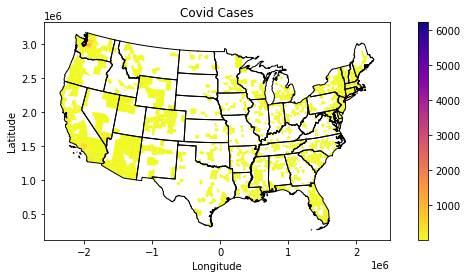

The country with the most cases was New York
 It had, 6226 cases.


In [137]:
nytimes = pd.read_csv("nytimes.csv")
county_data["fips"] = county_data["STATEFP"] + county_data["COUNTYFP"]  # Create fips in county data
county_data["fips"] = county_data["fips"].astype(float)  # Make datatype match

# Merge and drop
covid = county_data.merge(nytimes, on="fips")
covid = covid.to_crs(5071)
covid = covid[~covid["STATEFP"].isin(["02", "15", "60", "66", "69", "72", "78"])]

# Plot the data
fig, ax = plt.subplots(1, figsize=(10, 4))
ax.set_title("Covid Cases")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
base = state_data.boundary.plot(edgecolor="black", ax=ax, linewidth=1)
covid = covid[covid["date"]=="2020-03-21"]  # Only want specified date
covid.plot(ax=base, legend=True, cmap="plasma_r", column="cases")
plt.show()

# Print name of country with most cases on March 21, 2020
largest_case_row = covid.loc[covid["cases"].idxmax()]
largest_case_name = largest_case_row["NAME"]  # Extract the "Name" from that row
largest_case_count = largest_case_row["cases"] # Extract the "Cases" from that row
print(f"The country with the most cases was {largest_case_name}\n",
      f"It had, {largest_case_count} cases.")


## Problem 4

As in Problem 3, plot your state outline map from Problem 2 on top of a map of Covid-19 cases from March 21, 2020 (each with a CRS of EPSG:5071).
This time, however, use a log scale.
Pick a good colormap (the counties with the most cases should generally be darkest) and be sure to display a colorbar.

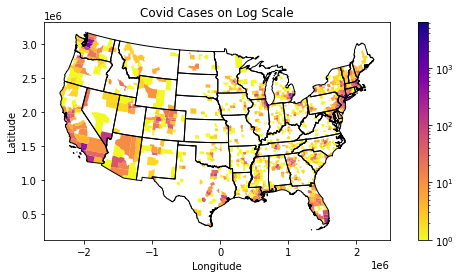

In [140]:
# Define norm
norm = LogNorm(vmin=covid["cases"].min(), vmax=covid["cases"].max())

# Plot the data but with log plot
fig, ax = plt.subplots(1, figsize=(10, 4))
ax.set_title("Covid Cases on Log Scale")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
base = state_data.boundary.plot(edgecolor="black", ax=ax, linewidth=1)
covid.plot(ax=base, legend=True, cmap="plasma_r", column="cases", norm=norm)
plt.show()


## Problem 5

In this problem, you will create an animation of the spread of Covid-19 through US counties from January 21, 2020, through June 21, 2020.
You will use the same GeoDataFrame you used in Problems 3 and 4 (with a CRS of EPSG:5071).
Use a log scale and a good colormap, and be sure that you're using the same norm and colorbar for the whole animation.

As a reminder, below is a summary of what you will need in order to animate this map.
You may also find it helpful to refer to the animation section included with the Volume 4 lab manual. 

- Set up your figure and norm. Be sure to use the highest case count for your *vmax* so that the scale remains uniform.
- Write your *update* function. This should plot the cases from a given day as well as the state boundaries.
- Set up your colorbar. Do this outside the *update* function to avoid adding a new colorbar each day.
- Create a *FuncAnimation* object. Check to make sure everything displays properly before you save it.
- Save the animation to a file, and embed it into the notebook.

In [156]:
plt.ioff()

# Get the data again
nytimes = pd.read_csv("nytimes.csv")
county_data["fips"] = county_data["STATEFP"] + county_data["COUNTYFP"]  # Create fips in county data
county_data["fips"] = county_data["fips"].astype(float)  # Make datatype match
covid = county_data.merge(nytimes, on="fips")
covid = covid.to_crs(5071)
covid = covid[~covid["STATEFP"].isin(["02", "15", "60", "66", "69", "72", "78"])]

# Set up the figure
fig, ax = plt.subplots(1, figsize=(10, 7))

# Define the color normalization for log scale
norm = LogNorm(vmin=covid["cases"].min(), vmax=covid["cases"].max())

# Set up the colorbar (with help from ChatGPT)
sm = plt.cm.ScalarMappable(cmap="plasma_r", norm=norm)
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("Cases (log scale)")

# Static boundaries (plot once outside the update function)
state_boundaries = state_data.boundary.plot(edgecolor="black", ax=ax, linewidth=1)

def update(date):
    ax.clear()  # Clear the previous frame
    state_boundaries = state_data.boundary.plot(edgecolor="black", ax=ax, linewidth=1)  # Replot boundaries
    covid_date = covid[covid["date"] == date]  # Filter data for the specific date
    # Plot Covid data for the specified date
    covid_date.plot(ax=state_boundaries, column="cases", cmap="plasma_r", norm=norm)
    
    # Reset title and labels (since ax.clear() removes them)
    ax.set_title(f"Covid Cases on Log Scale: {date}")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")

# Create the animation object
ani = animation.FuncAnimation(fig, update, 
                              frames=sorted(set(covid['date'])),  # Loop over dates
                              interval=1000 * (1/30),  # 30 frames per second
                              repeat=False)

plt.close(fig)

In [157]:
animation.writer = animation.writers['ffmpeg']

# Save / embed the animation

# Run this line and the following Markdown cell
ani.save('covid_spread.mp4')
# Don't forget to push the .mp4 file!

<Figure size 432x288 with 0 Axes>

<video src="covid_spread.mp4" controls>